# TicTacToe

TicTacToe implemented with neural network based learning player.  

Random players can be used to generate CSV.  Learning player can use historical data for training.  

In [623]:
from tictactoe.game import Game, Board
from tictactoe.players import InputPlayer, RandomPlayer, LearningPlayer
from tictactoe.data import Storage, Stats
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [624]:
width = 3
height = 3
game = Game(width=width, height=height)

In [625]:
player1 = RandomPlayer()
player1a = RandomPlayer()

In [626]:
player2 = LearningPlayer()

Generates a random move from random player

In [627]:
player1.get_move(game.board)

(1, 1)

Create 5 games for random players to play

In [924]:
def play_game(game, player_x, player_o):
    game.player_x = player1
    game.player_o = player1a
    game.start()
    game.end()
    return (game.id, game.winner, Board.serialize(game.board))
    
rounds = [play_game(game, player1, player1a) for i in range(5)]
rounds

[('0xc043', 'X', 'XOXOOXOXX'),
 ('0xa5bb', 'O', 'XO--OXXO-'),
 ('0x8a10', 'O', 'XXO-O-O-X'),
 ('0xfea4', 'X', 'OXXXOXOOX'),
 ('0x5577', 'X', 'XXXO-OXO-')]

Retrieve historical game sessions

In [925]:
def load(src):
    df_s = pd.read_csv(src)
    df_s = df_s.fillna('NA')
    return df_s

In [1151]:
df = load('data/0xe2c4.csv')
df = df.sort_values(by=['id'])
df.head()

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner,empty_spaces
4290,X,"(2, 1)",OXOXO-XOX,O,X,O,X,O,-,X,O,X,0x1048,NA,0
4289,O,"(1, 1)",OXOX--XOX,O,X,O,X,-,-,X,O,X,0x1048,NA,0
4288,X,"(2, 2)",OXOX--XO-,O,X,O,X,-,-,X,O,-,0x1048,NA,0
4287,O,"(0, 0)",-XOX--XO-,-,X,O,X,-,-,X,O,-,0x1048,NA,0
4286,X,"(0, 1)",-XO---XO-,-,X,O,-,-,-,X,O,-,0x1048,NA,0


List winners by marker

In [1152]:
def info(df_s):
    df_s = df_s.copy()
    df_s = df_s.groupby(['id', 'winner'], as_index=False).count()
    df_s['value'] = 1
    return df_s.groupby('winner')['value'].sum()

In [1153]:
info(df)

winner
NA     253
O      580
X     1157
Name: value, dtype: int64

In [1154]:
num_games = df.shape[0]
num_games

15351

Harmonize dataset to use learning values

In [1177]:
def harmonize(df_s):
    df_s = df_s.copy()
    df_s = df_s.replace('X', 1.)
    df_s = df_s.replace('O', -1.)
    df_s = df_s.replace('-', 0.)
    df_s = df_s[df_s['winner'] != 'NA']
    #     df_s = df_s.replace('NA', 0.)
    df_s['winner'] = df_s['marker'] * df_s['winner']
    return df_s

In [1181]:
harmonized_df = harmonize(df)
harmonized_df.head()

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner,empty_spaces
3302,-1.0,"(2, 2)",-------X-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0x1052,-1,0
3301,1.0,"(1, 2)",---------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x1052,1,0
3305,-1.0,"(0, 2)",X------XO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0x1052,-1,0
3307,1.0,"(2, 1)",X-----OXO,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0x1052,1,0
3309,-1.0,"(1, 1)",X----XOXO,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,-1.0,0x1052,-1,0


In [1182]:
harmonized_df.shape

(13074, 15)

In [1183]:
train_df, test_df = train_test_split(harmonized_df, test_size=0.2)

In [1184]:
train_df.head()

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner,empty_spaces
10496,1.0,"(1, 0)",----X---O,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0x29c2,-1,1
8050,1.0,"(1, 2)",-XXO----O,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0xfe92,1,2
10194,1.0,"(1, 2)",XXO-----O,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0x9b60,-1,1
1406,-1.0,"(0, 0)",---X--XO-,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0x8901,-1,0
2116,-1.0,"(1, 0)",--X---X-O,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0x330b,1,1


In [1185]:
test_df.head()

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner,empty_spaces
1052,-1.0,"(1, 1)",-XOO-X-X-,0.0,1.0,-1.0,-1.0,0.0,1.0,0.0,1.0,0.0,0xb06d,-1,0
11310,-1.0,"(2, 0)",XO-O-X-X-,1.0,-1.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0x884,-1,0
8144,1.0,"(1, 2)",----XO---,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0x852d,1,2
7441,1.0,"(1, 2)",XOO-O-X-X,1.0,-1.0,-1.0,0.0,-1.0,0.0,1.0,0.0,1.0,0xa2a1,1,2
12280,-1.0,"(1, 0)",-------X-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0x8e76,-1,0


Build inputs

In [1247]:
def parse_input_x(df_s):
    df_s = df_s.copy()
    filter_cols = ('id', 'board', 'move', 'empty_spaces')
    for col in filter_cols:
        df_s = df_s.drop(col, axis=1)
    #return df_s
    return np.array(df_s.values.T, dtype=np.float64)

In [1248]:
train_x = parse_input_x(train_df)
train_x

array([[ 1.,  1.,  1., ...,  1., -1.,  1.],
       [ 0.,  0.,  1., ..., -1.,  0.,  1.],
       [ 0.,  1.,  1., ...,  1.,  0., -1.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [-1., -1., -1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ...,  1.,  1., -1.]])

In [1249]:
def parse_output_y(df_s):
    coords = df_s.columns[3:3+width*height]
    df_s = df_s.copy()
    filter_cols = ('id', 'marker', 'empty_spaces')
    for col in filter_cols:
        df_s = df_s.drop(col, axis=1)
    for coord in coords:
        df_s[coord] = (coord == df_s['move']) * 1.
    filter_cols = ('move', 'winner', 'board')
    for col in filter_cols:
        df_s = df_s.drop(col, axis=1)
    return np.array(df_s.values.T, dtype=np.float64)


In [1250]:
train_y = parse_output_y(train_df)
train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1251]:
train_x.shape

(11, 10459)

In [1252]:
train_y.shape

(9, 10459)

In [1253]:
test_x = parse_input_x(test_df)
test_y = parse_output_y(test_df)


In [1254]:
test_x.shape

(11, 2615)

In [1255]:
test_y.shape

(9, 2615)

In [1256]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x)* 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)* 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [1257]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [1258]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [1259]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [1260]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    assert(AL.shape[1] == X.shape[1])
            
    return AL, caches

In [1261]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y, np.log(AL).T) - np.dot(1. - Y, np.log(1. - AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    #assert(cost.shape == ())
    
    return cost

In [1262]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [1263]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [1264]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
        dAL,
        current_cache,
        'sigmoid'
    )
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(L-1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [1265]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [1266]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1 + np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [1267]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0090, num_iterations = 2500, print_cost=False, print_freq=100):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        avg_cost = np.average(cost)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % print_freq == 0:
            print ("iteration: %i learning_rate: %f cost: %f" %(i, learning_rate, avg_cost))
        if print_cost and i % print_freq == 0:
            costs.append(avg_cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [1268]:
train_x.shape

(11, 10459)

In [1269]:
layers_dims = (train_x.shape[0], 24, train_y.shape[0])
layers_dims

(11, 24, 9)

iteration: 0 learning_rate: 0.090000 cost: 0.748010
iteration: 100 learning_rate: 0.090000 cost: 0.355896
iteration: 200 learning_rate: 0.090000 cost: 0.353719
iteration: 300 learning_rate: 0.090000 cost: 0.353161
iteration: 400 learning_rate: 0.090000 cost: 0.353025
iteration: 500 learning_rate: 0.090000 cost: 0.353074
iteration: 600 learning_rate: 0.090000 cost: 0.353254
iteration: 700 learning_rate: 0.090000 cost: 0.353563
iteration: 800 learning_rate: 0.090000 cost: 0.353977
iteration: 900 learning_rate: 0.090000 cost: 0.354531
iteration: 1000 learning_rate: 0.090000 cost: 0.355242
iteration: 1100 learning_rate: 0.090000 cost: 0.356218
iteration: 1200 learning_rate: 0.090000 cost: 0.357488
iteration: 1300 learning_rate: 0.090000 cost: 0.359092
iteration: 1400 learning_rate: 0.090000 cost: 0.361025
iteration: 1500 learning_rate: 0.090000 cost: 0.363222
iteration: 1600 learning_rate: 0.090000 cost: 0.365685
iteration: 1700 learning_rate: 0.090000 cost: 0.368341
iteration: 1800 learni

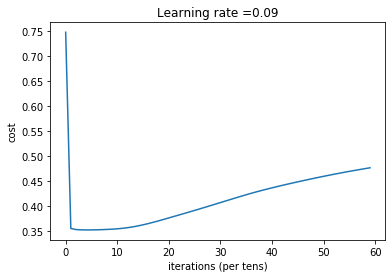

In [1271]:
parameters = L_layer_model(train_x, train_y, layers_dims, 
                           learning_rate = 0.009, 
                           num_iterations = 6000, 
                           print_cost=True, 
                           print_freq=100)

In [1245]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    
    return probas


In [1246]:
pred_train = predict(train_x, train_y, parameters)
pd.DataFrame(pred_train).T.head()

Accuracy: 7.999999999999998


,0,1,2,3,4,5,6,7,8
0,0.090970,0.168984,0.078128,0.119127,0.052317,0.079094,0.059722,0.117851,0.105879
1,0.111790,0.062972,0.040155,0.084195,0.118627,0.069714,0.044918,0.065308,0.055156
2,0.086027,0.084865,0.050375,0.064062,0.051852,0.074620,0.011549,0.130104,0.088166
3,0.144857,0.238119,0.209309,0.207966,0.127693,0.137548,0.189334,0.186817,0.193587
4,0.265694,0.185306,0.174929,0.135551,0.305254,0.183519,0.242276,0.168271,0.228710


In [1243]:
pd.DataFrame(train_y).T.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
